# XAI Methods 

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.impute import KNNImputer
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer

import joblib

## Preprocessing/Formatting

Cleaning dataset, reworking to appropriate format, and creating an easy csv for reuse.

In [2]:
raw_df = pd.read_excel('./WEOOct2023allfix.xlsx', header=0, engine='openpyxl')
raw_df = raw_df.iloc[0:8624]

ISO = raw_df['ISO'].unique()
country_list = raw_df['Country'].unique()
ISO_dict = {ISO[n]: country_list[n] for n in range(len(country_list))}

advanced_economies = ['Andorra', 'Australia', 'Austria', 'Belgium', 'Canada', 'Croatia', 'Cyprus', 'Czech Republic', 'Denmark',
                      'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hong Kong SAR', 'Iceland', 'Ireland', 'Israel', 'Italy',
                      'Japan', 'Korea', 'Latvia', 'Lithuania', 'Luxembourg', 'Macao SAR', 'Malta', 'Netherlands', 'New Zealand',
                      'Norway', 'Portugal', 'Puerto Rico', 'San Marino', 'Singapore', 'Slovak Republic', 'Slovenia', 'Spain', 'Sweden',
                      'Switzerland', 'Taiwan Province of China', 'United Kingdom', 'United States']

target_dict = {}
for key in ISO_dict:
    if ISO_dict[key] in advanced_economies:
        target_dict[key] = 1
    else:
        target_dict[key] = 0

In [3]:
def rename_mapper(df, list_to_rename, new_names):
    '''
    For use in df_IMF_oneyear. Renames columns after unit conversion to dollars
    '''
    rename_map = {}
    for i in range(len(list_to_rename)):
        rename_map[list_to_rename[i]] = new_names[i]
    return df.rename(columns=rename_map)

def df_IMF_oneyear(raw_df, year, target_dict):
    '''
    This creates a DataFrame from the IMF WEO dataset for a single year,
    reshapes it into a usable format, adds target information, drops rows of
    marginal value, converts National Currencies into US Dollar values, and
    gives us a metadata DataFrame.

    This will feed into a larger Dataframe of multiple years.
    '''

    # create metadata and unique feature names for final df
    metadata_df = raw_df[['Subject Descriptor', 'Subject Notes', 'Units', 'Scale']].iloc[0:44, :]
    metadata_df['Unique Name'] = metadata_df['Subject Descriptor'] + ' in ' + metadata_df['Units']
    features = metadata_df['Unique Name']

    # create year slice of df
    df = raw_df[['ISO','Subject Descriptor', year]]

    data_store = []
    for x in range(196):
        data_store.append(df[year].iloc[x*44:(x+1)*44].to_numpy())

    df_reworked = pd.DataFrame(data_store, index=df['ISO'].unique(), columns=features)

    # Add targets 1 for Advanced 0 for Developing
    df_reworked['target'] = list(target_dict.values())

    # Drop rows and columns as explored above
    df_reworked.drop(labels='SYR', axis=0, inplace=True)
    df_reworked.drop(labels=['Gross domestic product per capita, current prices in National currency',
                             'Output gap in percent of potential GDP in Percent of potential GDP',
                            'Employment in Persons'], axis=1, inplace=True) # May need to add more later

    # Venezuela's data had a string as opposed to NaN in certain places. This fixes it as well as the dtype of the column.
    df_reworked.replace(to_replace='--', value=np.nan, inplace=True)


    # Perform unit conversions to US dollar
    # Value in US dollars = Value in National Currency * (GDP in dollars / GDP in National Currency)
    conversion_list = ['Gross domestic product, constant prices in National currency',
                       'Gross domestic product per capita, constant prices in National currency',
                       'General government revenue in National currency',
                       'General government total expenditure in National currency',
                       'General government net lending/borrowing in National currency',
                       'General government structural balance in National currency',
                       'General government primary net lending/borrowing in National currency',
                       'General government net debt in National currency',
                       'General government gross debt in National currency',
                       'Gross domestic product corresponding to fiscal year, current prices in National currency'
                      ]

    conversion_rate = df_reworked['Gross domestic product, current prices in U.S. dollars'] / df_reworked['Gross domestic product, current prices in National currency']

    # Applies conversion
    for value in conversion_list:
        df_reworked[value] = df_reworked[value] * conversion_rate

        rename_list = ['Gross domestic product, constant prices in US dollars',
                       'Gross domestic product per capita, constant prices in US dollars',
                       'General government revenue in US dollars',
                       'General government total expenditure in US dollars',
                       'General government net lending/borrowing in US dollars',
                       'General government structural balance in US dollars',
                       'General government primary net lending/borrowing in US dollars',
                       'General government net debt in US dollars',
                       'General government gross debt in US dollars',
                       'Gross domestic product corresponding to fiscal year, current prices in US dollars'
                      ]

    # Rename columns to reflect new units
    rename_mapper = {}
    for i in range(len(rename_list)):
        rename_mapper[conversion_list[i]] = rename_list[i]
    df_reworked.rename(columns=rename_mapper, inplace=True)

    # Drop Gross domestic product, current prices in National currency after conversion due to it being extraeneous.
    df_reworked.drop(labels='Gross domestic product, current prices in National currency', axis=1, inplace=True)


    return df_reworked, metadata_df # Need to rework Metadata df to reflect changes to DF

def df_IMF_full(raw_df, year_range, target_dict):
    '''
    This function will create a Dataframe of the IMF WEO data for several years.
    It creates unique indices by using the country ISO and year
    For example: USA 2017 could be an index name.
    '''

    first = False
    for year in year_range:
        oneyear_df, metadata_df = df_IMF_oneyear(raw_df, year, target_dict)

        new_index = oneyear_df.index + ' ' + str(year)
        oneyear_df.index = new_index

        if not first:
          full_df = oneyear_df.copy()
          first = True
        else:
          full_df = pd.concat([full_df, oneyear_df])

    return full_df

In [10]:
full_df = df_IMF_full(raw_df, [2017, 2018, 2019, 2020, 2021], target_dict)
full_df

C:\Users\dblan\AppData\Local\Temp\ipykernel_298128\3177207800.py:44: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_reworked.replace(to_replace='--', value=np.nan, inplace=True)
C:\Users\dblan\AppData\Local\Temp\ipykernel_298128\3177207800.py:44: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_reworked.replace(to_replace='--', value=np.nan, inplace=True)
C:\Users\dblan\AppData\Local\Temp\ipykernel_298128\3177207800.py:44: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To 

Unique Name,"Gross domestic product, constant prices in US dollars","Gross domestic product, constant prices in Percent change","Gross domestic product, current prices in U.S. dollars","Gross domestic product, current prices in Purchasing power parity; international dollars","Gross domestic product, deflator in Index","Gross domestic product per capita, constant prices in US dollars","Gross domestic product per capita, constant prices in Purchasing power parity; 2017 international dollar","Gross domestic product per capita, current prices in U.S. dollars","Gross domestic product per capita, current prices in Purchasing power parity; international dollars",Gross domestic product based on purchasing-power-parity (PPP) share of world total in Percent,...,General government primary net lending/borrowing in US dollars,General government primary net lending/borrowing in Percent of GDP,General government net debt in US dollars,General government net debt in Percent of GDP,General government gross debt in US dollars,General government gross debt in Percent of GDP,"Gross domestic product corresponding to fiscal year, current prices in US dollars",Current account balance in U.S. dollars,Current account balance in Percent of GDP,target
AFG 2017,18.439812,2.647,18.883,74.712,102.404,620.867828,2515.55,635.789,2515.55,0.061,...,-0.114095,-0.604,NaN,NaN,1.510202,7.998,18.883,1.431,7.576,0
ALB 2017,6.641133,3.802,13.053,37.609,196.547,2302.614606,13039.70,4525.890,13039.70,0.031,...,0.085095,0.652,8.550340,65.505,9.384372,71.895,13.053,-0.978,-7.492,0
DZA 2017,66.530313,1.400,167.498,478.068,251.762,1594.648371,11458.70,4014.710,11458.70,0.390,...,-12.815120,-7.651,36.146915,21.580,45.629785,27.242,167.498,-22.331,-13.332,0
AND 2017,2.908484,0.346,2.993,4.215,102.912,38880.873012,56352.20,40017.740,56352.20,0.003,...,NaN,NaN,NaN,NaN,1.132517,37.854,2.993,NaN,NaN,1
AGO 2017,9.562574,-0.150,122.022,217.805,1276.040,316.550576,7210.03,4039.300,7210.03,0.178,...,-3.615948,-2.963,NaN,NaN,84.589167,69.323,122.022,-0.633,-0.519,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VNM 2021,223.855231,2.560,369.736,1143.070,165.167,2272.498902,10516.21,3753.430,11604.08,0.771,...,-0.861411,-0.233,NaN,NaN,144.602791,39.110,369.736,-8.150,-2.204,0
WBG 2021,18.075256,7.012,18.109,30.642,100.186,3457.919370,5312.50,3464.380,5862.06,0.021,...,NaN,NaN,NaN,NaN,9.086386,50.176,18.109,-1.778,-9.818,0
YEM 2021,0.203280,-1.000,19.263,62.444,9476.070,6.227766,1733.71,590.136,1913.05,0.042,...,0.043460,0.226,13.889348,72.104,14.336720,74.426,19.263,-2.972,-15.430,0
ZMB 2021,7.197968,4.599,22.148,69.551,307.698,369.636044,3236.80,1137.340,3571.64,0.047,...,-0.453289,-2.047,24.185950,109.201,24.537731,110.790,22.148,2.138,9.652,0


In [11]:
full_df.to_csv("./processed_data.csv")

## Read-in

Need to remake easynames with key, redefine model and data splits so I can get the results with the saved model.

In [4]:
df = pd.read_csv("./processed_data.csv", index_col=0)
df

,"Gross domestic product, constant prices in US dollars","Gross domestic product, constant prices in Percent change","Gross domestic product, current prices in U.S. dollars","Gross domestic product, current prices in Purchasing power parity; international dollars","Gross domestic product, deflator in Index","Gross domestic product per capita, constant prices in US dollars","Gross domestic product per capita, constant prices in Purchasing power parity; 2017 international dollar","Gross domestic product per capita, current prices in U.S. dollars","Gross domestic product per capita, current prices in Purchasing power parity; international dollars",Gross domestic product based on purchasing-power-parity (PPP) share of world total in Percent,...,General government primary net lending/borrowing in US dollars,General government primary net lending/borrowing in Percent of GDP,General government net debt in US dollars,General government net debt in Percent of GDP,General government gross debt in US dollars,General government gross debt in Percent of GDP,"Gross domestic product corresponding to fiscal year, current prices in US dollars",Current account balance in U.S. dollars,Current account balance in Percent of GDP,target
AFG 2017,18.439812,2.647,18.883,74.712,102.404,620.867828,2515.55,635.789,2515.55,0.061,...,-0.114095,-0.604,NaN,NaN,1.510202,7.998,18.883,1.431,7.576,0
ALB 2017,6.641133,3.802,13.053,37.609,196.547,2302.614606,13039.70,4525.890,13039.70,0.031,...,0.085095,0.652,8.550340,65.505,9.384372,71.895,13.053,-0.978,-7.492,0
DZA 2017,66.530313,1.400,167.498,478.068,251.762,1594.648371,11458.70,4014.710,11458.70,0.390,...,-12.815120,-7.651,36.146915,21.580,45.629785,27.242,167.498,-22.331,-13.332,0
AND 2017,2.908484,0.346,2.993,4.215,102.912,38880.873012,56352.20,40017.740,56352.20,0.003,...,NaN,NaN,NaN,NaN,1.132517,37.854,2.993,NaN,NaN,1
AGO 2017,9.562574,-0.150,122.022,217.805,1276.040,316.550576,7210.03,4039.300,7210.03,0.178,...,-3.615948,-2.963,NaN,NaN,84.589167,69.323,122.022,-0.633,-0.519,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VNM 2021,223.855231,2.560,369.736,1143.070,165.167,2272.498902,10516.21,3753.430,11604.08,0.771,...,-0.861411,-0.233,NaN,NaN,144.602791,39.110,369.736,-8.150,-2.204,0
WBG 2021,18.075256,7.012,18.109,30.642,100.186,3457.919370,5312.50,3464.380,5862.06,0.021,...,NaN,NaN,NaN,NaN,9.086386,50.176,18.109,-1.778,-9.818,0
YEM 2021,0.203280,-1.000,19.263,62.444,9476.070,6.227766,1733.71,590.136,1913.05,0.042,...,0.043460,0.226,13.889348,72.104,14.336720,74.426,19.263,-2.972,-15.430,0
ZMB 2021,7.197968,4.599,22.148,69.551,307.698,369.636044,3236.80,1137.340,3571.64,0.047,...,-0.453289,-2.047,24.185950,109.201,24.537731,110.790,22.148,2.138,9.652,0


In [5]:
col_names = df.columns.tolist()
new_names = ['x' + str(i) for i in range(len(col_names)-1)]+['y']

df_easynames = rename_mapper(df, col_names, new_names)
df_easynames.columns

Index(['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10',
       'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19', 'x20',
       'x21', 'x22', 'x23', 'x24', 'x25', 'x26', 'x27', 'x28', 'x29', 'x30',
       'x31', 'x32', 'x33', 'x34', 'x35', 'x36', 'x37', 'x38', 'x39', 'y'],
      dtype='object')

In [8]:
col_names

['Gross domestic product, constant prices in US dollars',
 'Gross domestic product, constant prices in Percent change',
 'Gross domestic product, current prices in U.S. dollars',
 'Gross domestic product, current prices in Purchasing power parity; international dollars',
 'Gross domestic product, deflator in Index',
 'Gross domestic product per capita, constant prices in US dollars',
 'Gross domestic product per capita, constant prices in Purchasing power parity; 2017 international dollar',
 'Gross domestic product per capita, current prices in U.S. dollars',
 'Gross domestic product per capita, current prices in Purchasing power parity; international dollars',
 'Gross domestic product based on purchasing-power-parity (PPP) share of world total in Percent',
 'Implied PPP conversion rate in National currency per current international dollar',
 'Total investment in Percent of GDP',
 'Gross national savings in Percent of GDP',
 'Inflation, average consumer prices in Index',
 'Inflation, a

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    df_easynames.drop('y', axis=1), df_easynames['y'], test_size=0.2,
    random_state=631, stratify=df_easynames['y'])

In [7]:
loaded_rf_model = joblib.load('forest_model.sav')

In [8]:
y_test_pred_rf = loaded_rf_model.predict(X_test)

f1_rf = f1_score(y_test, y_test_pred_rf)
precision_rf = precision_score(y_test, y_test_pred_rf)
recall_rf = recall_score(y_test, y_test_pred_rf)

print('\nTest Scores for Random Forest Model:')
print(f'F1 Score (Test): {f1_rf}')
print(f'Precision (Test): {precision_rf}')
print(f'Recall (Test): {recall_rf}')


Test Scores for Random Forest Model:
F1 Score (Test): 0.975609756097561
Precision (Test): 0.975609756097561
Recall (Test): 0.975609756097561


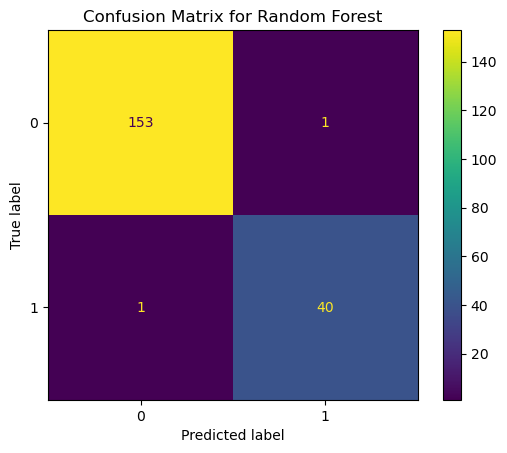

In [9]:
cm_rf = confusion_matrix(y_test, y_test_pred_rf)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf)
disp.plot()
plt.title('Confusion Matrix for Random Forest')
plt.savefig('cm.png')
plt.show()

In [10]:
pred_adv = []
pred_dev = []

diffs = np.where(y_test != y_test_pred_rf)[0]
diffs
for i in diffs:
  if y_test_pred_rf[i] == 0:
      pred_dev.append(i)
  else:
    pred_adv.append(i)

# print(pred_dev)
print('Predicted Developing, Actually Advanced:')
for i in pred_dev:
  print(X_test.iloc[i].name)

# print(pred_adv)
print('\nPredicted Advanced, Actually Developing:')
for i in pred_adv:
  print(X_test.iloc[i].name)

Predicted Developing, Actually Advanced:
HRV 2017

Predicted Advanced, Actually Developing:
OMN 2021


In [60]:
df.index.get_loc('HRV 2017')

43

In [61]:
df.index.get_loc('OMN 2021')

910

### Predicted Probabilities

We look at the probabilities of the predictions. We are most interested in looking at the data points closest to even chance of prediction. These are the most interesting for counterfactuals as the are closest to crossing over the boundary.

In [10]:
y_pred = pd.DataFrame(y_test_pred_rf, index=X_test.index, columns=['Pred'])

In [11]:
X_test_proba = pd.DataFrame(loaded_rf_model.predict_proba(X_test))
X_test_proba.index = X_test.index
df_test_proba = pd.concat([X_test_proba, y_test, y_pred], axis=1)
# df_test_proba = pd.DataFrame(test_data)
df_test_proba

,0,1,y,Pred
KAZ 2021,1.00,0.00,0,0
COD 2020,1.00,0.00,0,0
BGD 2019,1.00,0.00,0,0
BTN 2019,0.98,0.02,0,0
RUS 2021,0.78,0.22,0,0
...,...,...,...,...
ALB 2017,1.00,0.00,0,0
COD 2019,1.00,0.00,0,0
NAM 2018,1.00,0.00,0,0
VNM 2017,0.99,0.01,0,0


In [12]:
df_test_proba[(df_test_proba[0] >= 0.4) & (df_test_proba[0] <= 0.6)]

,0,1,y,Pred
OMN 2021,0.45,0.55,0,1
HRV 2018,0.41,0.59,1,1


In [13]:
df_test_proba.loc['HRV 2017']

0       0.71
1       0.29
y       1.00
Pred    0.00
Name: HRV 2017, dtype: float64

In [14]:
df_test_proba[(df_test_proba[0] >= 0.33) & (df_test_proba[0] <= 0.67)]

,0,1,y,Pred
SVK 2017,0.36,0.64,1,1
OMN 2021,0.45,0.55,0,1
USA 2021,0.33,0.67,1,1
HRV 2018,0.41,0.59,1,1


<Axes: xlabel='0', ylabel='Count'>

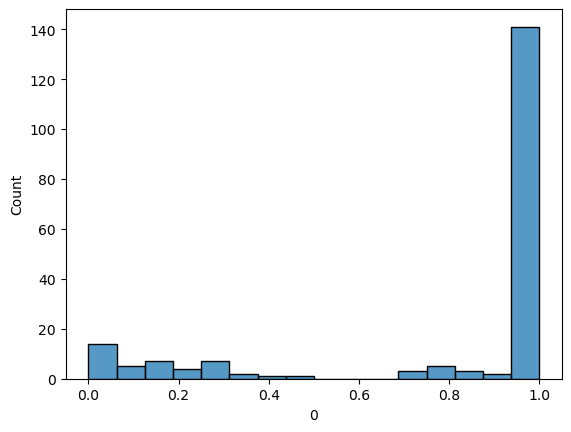

In [15]:
sns.histplot(df_test_proba[0])

<Axes: xlabel='1', ylabel='Count'>

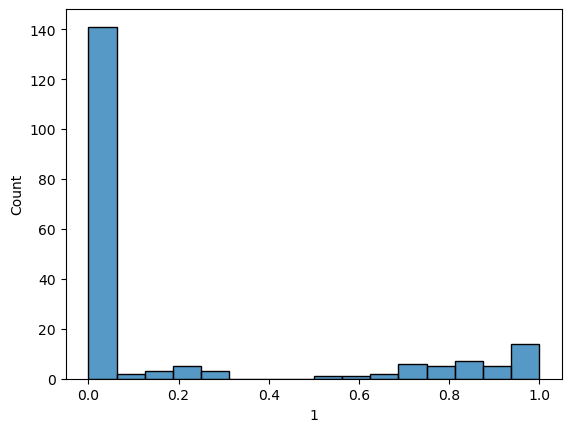

In [16]:
sns.histplot(df_test_proba[1])

## Feature Attribution

Use SHAP. Potentially look at the thing Hashim used

Need to preprocess with knn appropriately.

Need to figure out regime for testing.

In [11]:
import shap

In [12]:
knn_imputer = KNNImputer(n_neighbors=3)

df_imputed = pd.DataFrame(knn_imputer.fit_transform(X_test))
df_imputed.index = X_test.index
df_imputed.columns = X_test.columns

In [13]:
explainer = shap.TreeExplainer(loaded_rf_model['model'], data=df_imputed, model_output="probability")
shap_values = explainer(df_imputed)

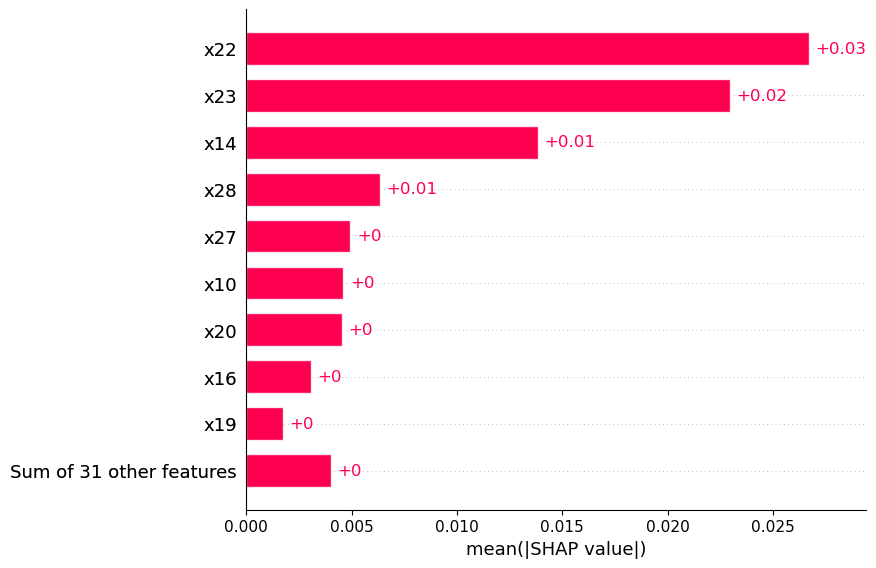

In [17]:
shap.plots.bar(shap_values[:,:,1])

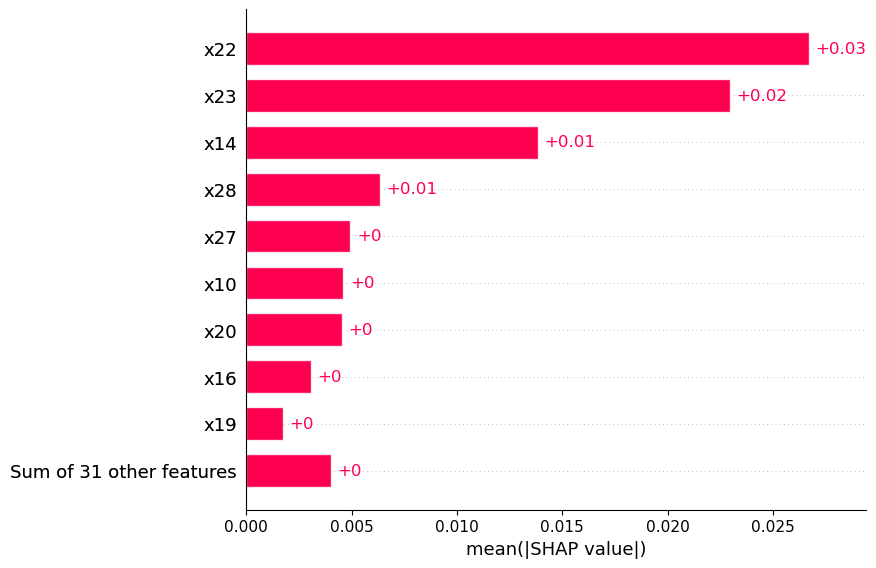

In [15]:
shap.plots.bar(shap_values[:,:,0])

#### Waterfall

In [22]:
df_imputed.index.get_loc('HRV 2017')

187

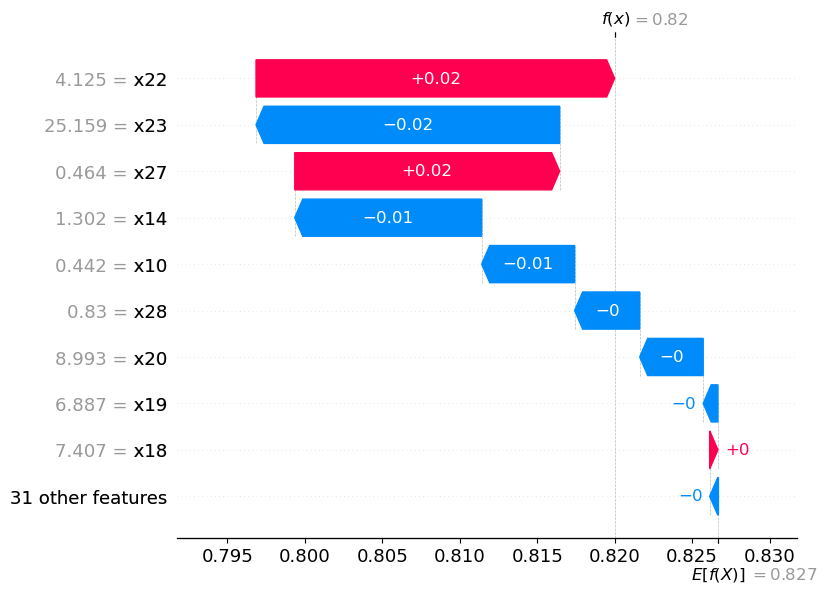

In [36]:
shap.plots.waterfall(shap_values[187,:,0])

In [69]:
df_imputed.index.get_loc('OMN 2021')

95

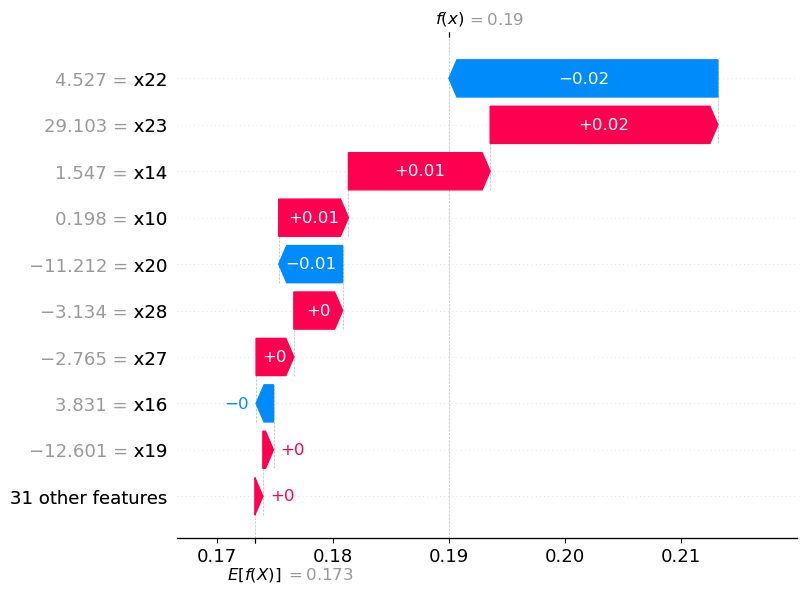

In [33]:
shap.plots.waterfall(shap_values[95, :, 1])

In [34]:
shap_values[95, :, 1]

.values =
array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  2.99999993e-04,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  5.99999987e-03,  0.00000000e+00,
       -2.00000005e-04,  0.00000000e+00,  1.21999997e-02,  0.00000000e+00,
       -1.49999997e-03,  4.16666656e-04, -4.00000000e-04,  9.16666640e-04,
       -5.49999988e-03,  0.00000000e+00, -2.31499995e-02,  1.95999996e-02,
        0.00000000e+00,  4.66666659e-04,  0.00000000e+00,  3.24999993e-03,
        4.19999991e-03,  9.99999978e-05,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00])

.base_values =
0.1733000000000001

.data =
array([ 9.01191682e+01,  3.09200000e+00,  8.81920000e+01,  1.71066000e+02,
        9.78620000e+01,  1.99048382e+04,  3.42419700e+04,  1.94794000e+04,
        3.77842200e+04,  1.15000000e-01,  1.9

In [39]:
from scipy.special import expit

prob_class_1 = expit(0.19)
prob_class_1

0.5473576181430894

In [41]:
prob_class_0 = expit(0.82)
prob_class_0

0.6942363401080305

Correctly suggesting mismatch?

In [29]:
shap_values[95, :, 0]

.values =
array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -2.99999993e-04,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -5.99999987e-03,  0.00000000e+00,
        1.99999991e-04,  0.00000000e+00, -1.21999997e-02,  0.00000000e+00,
        1.49999997e-03, -4.16666656e-04,  4.00000000e-04, -9.16666640e-04,
        5.49999988e-03,  0.00000000e+00,  2.31499995e-02, -1.95999996e-02,
        0.00000000e+00, -4.66666655e-04,  0.00000000e+00, -3.24999993e-03,
       -4.19999991e-03, -9.99999978e-05,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00])

.base_values =
0.8267000000000005

.data =
array([ 9.01191682e+01,  3.09200000e+00,  8.81920000e+01,  1.71066000e+02,
        9.78620000e+01,  1.99048382e+04,  3.42419700e+04,  1.94794000e+04,
        3.77842200e+04,  1.15000000e-01,  1.9

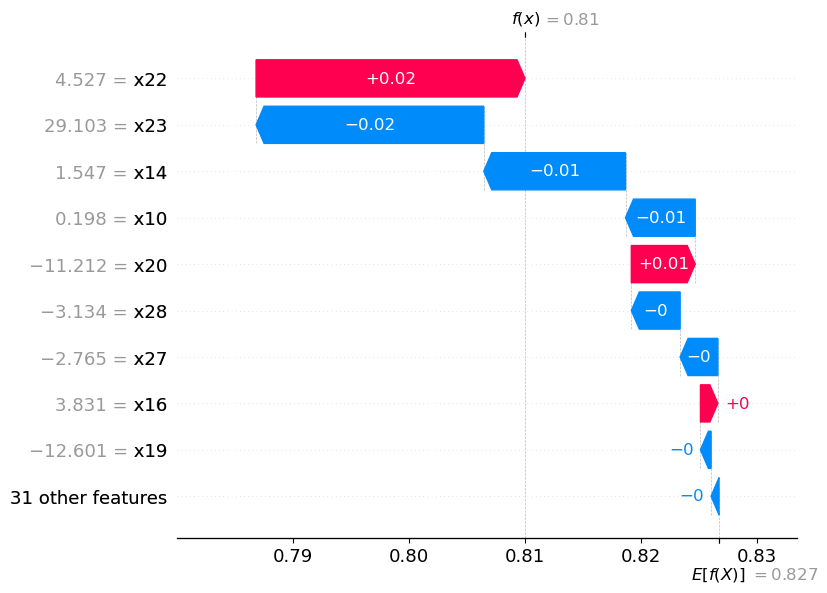

In [27]:
shap.plots.waterfall(shap_values[95, :, 0])

In [68]:
df_imputed.index.get_loc('KAZ 2021')

0

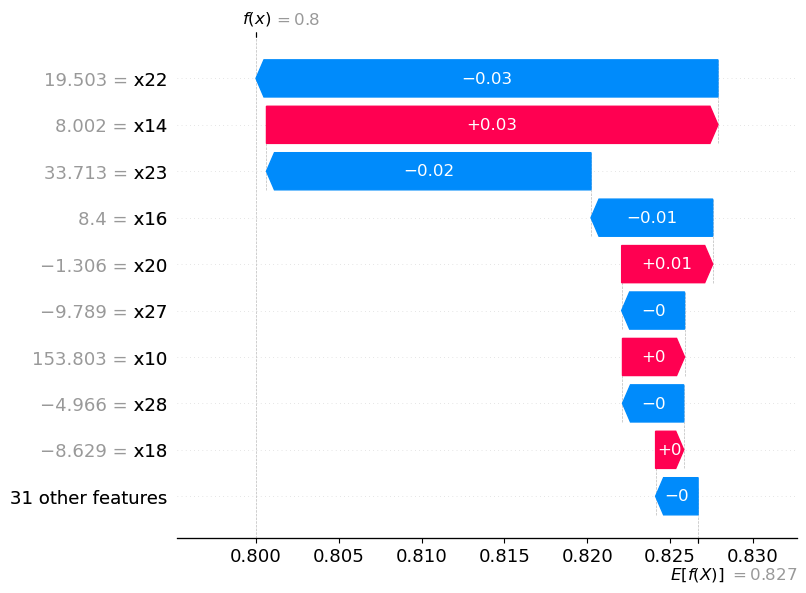

In [67]:
shap.plots.waterfall(shap_values[0, :, 0])

In [25]:
df_imputed.index.get_loc('SVK 2017')

46

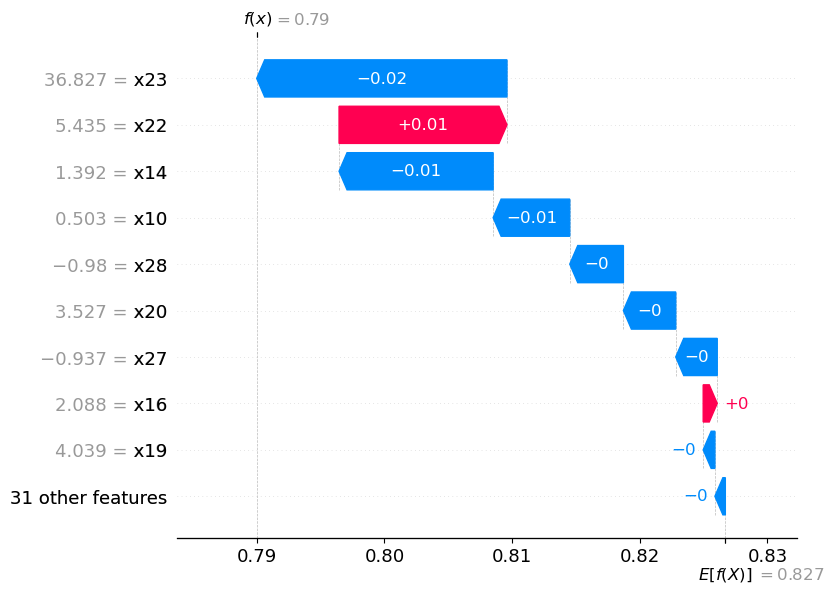

In [26]:
shap.plots.waterfall(shap_values[46,:,0])

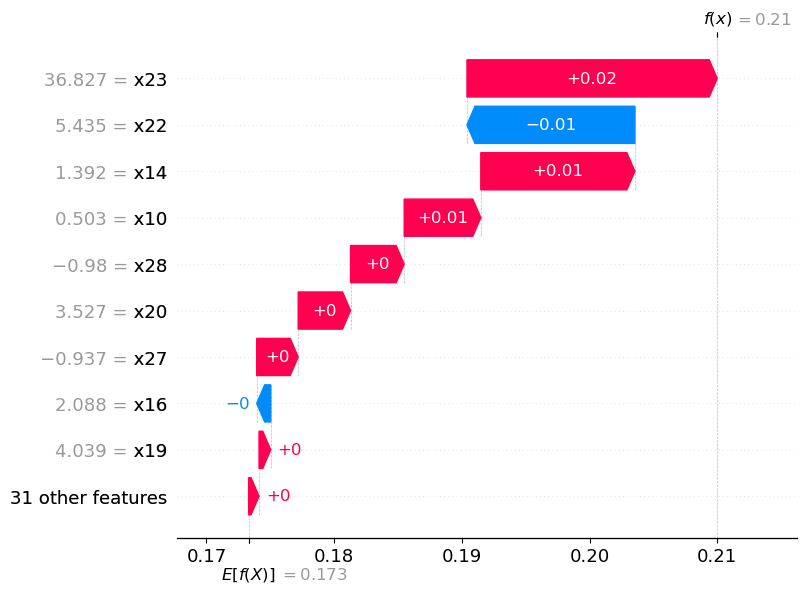

In [42]:
shap.plots.waterfall(shap_values[46,:,1])

In [43]:
prob_class_0 = expit(0.79)
prob_class_0

0.6878313305828404

In [44]:
prob_class_1 = expit(0.21)
prob_class_1

0.5523079095743253

In [45]:
df_imputed.index.get_loc('ITA 2017')

194

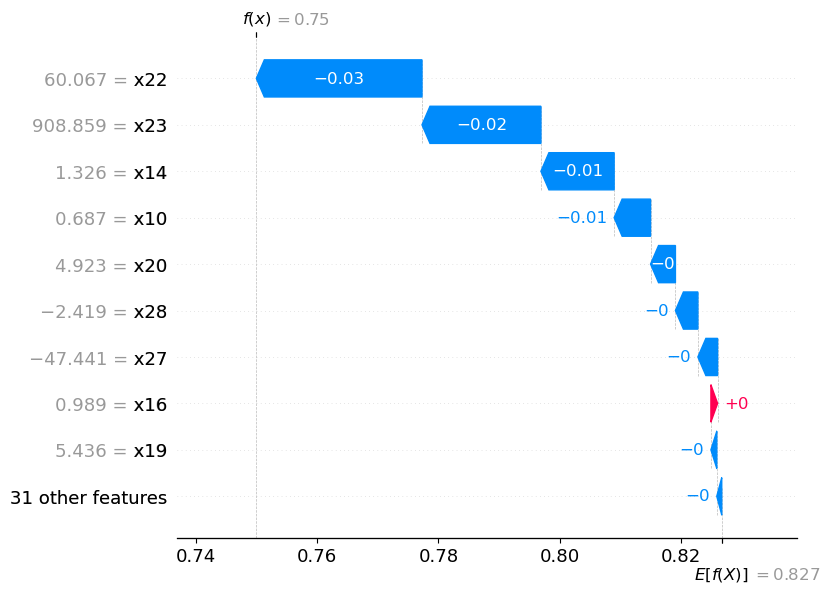

In [46]:
shap.plots.waterfall(shap_values[194,:,0])

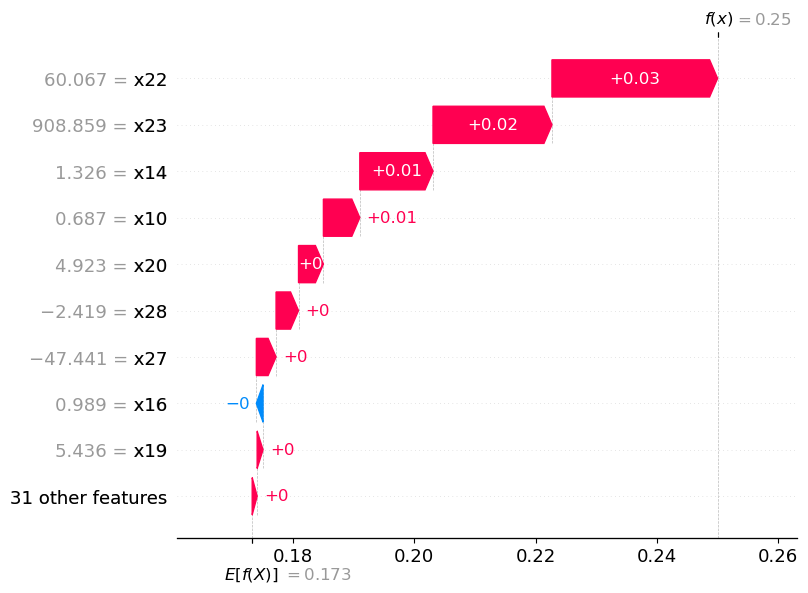

In [47]:
shap.plots.waterfall(shap_values[194,:,1])

#### Beeswarm

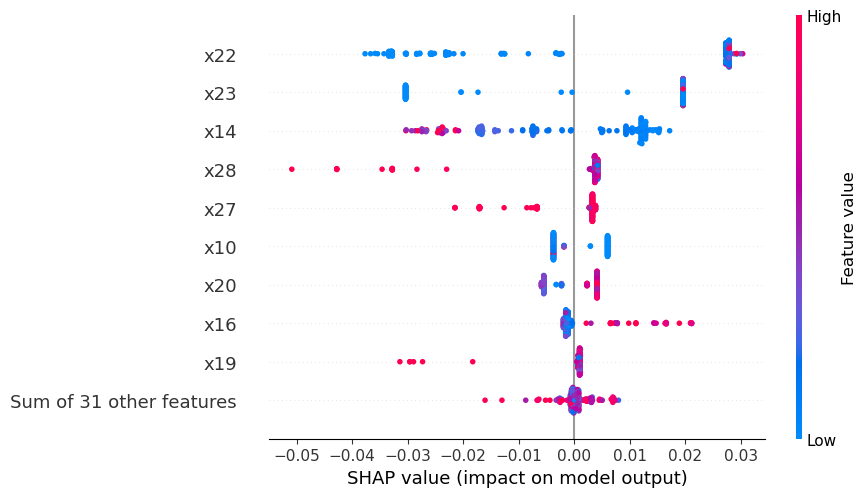

In [22]:
shap.plots.beeswarm(shap_values[:,:,1])

## Counterfactual

Consider counterfactual. Try DiCE https://github.com/interpretml/DiCE

### DiCE

In [25]:
import dice_ml
from dice_ml.utils import helpers

In [26]:
df_easynames

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x31,x32,x33,x34,x35,x36,x37,x38,x39,y
AFG 2017,18.439812,2.647,18.883,74.712,102.404,620.867828,2515.55,635.789,2515.55,0.061,...,-0.114095,-0.604,NaN,NaN,1.510202,7.998,18.883,1.431,7.576,0
ALB 2017,6.641133,3.802,13.053,37.609,196.547,2302.614606,13039.70,4525.890,13039.70,0.031,...,0.085095,0.652,8.550340,65.505,9.384372,71.895,13.053,-0.978,-7.492,0
DZA 2017,66.530313,1.400,167.498,478.068,251.762,1594.648371,11458.70,4014.710,11458.70,0.390,...,-12.815120,-7.651,36.146915,21.580,45.629785,27.242,167.498,-22.331,-13.332,0
AND 2017,2.908484,0.346,2.993,4.215,102.912,38880.873012,56352.20,40017.740,56352.20,0.003,...,NaN,NaN,NaN,NaN,1.132517,37.854,2.993,NaN,NaN,1
AGO 2017,9.562574,-0.150,122.022,217.805,1276.040,316.550576,7210.03,4039.300,7210.03,0.178,...,-3.615948,-2.963,NaN,NaN,84.589167,69.323,122.022,-0.633,-0.519,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VNM 2021,223.855231,2.560,369.736,1143.070,165.167,2272.498902,10516.21,3753.430,11604.08,0.771,...,-0.861411,-0.233,NaN,NaN,144.602791,39.110,369.736,-8.150,-2.204,0
WBG 2021,18.075256,7.012,18.109,30.642,100.186,3457.919370,5312.50,3464.380,5862.06,0.021,...,NaN,NaN,NaN,NaN,9.086386,50.176,18.109,-1.778,-9.818,0
YEM 2021,0.203280,-1.000,19.263,62.444,9476.070,6.227766,1733.71,590.136,1913.05,0.042,...,0.043460,0.226,13.889348,72.104,14.336720,74.426,19.263,-2.972,-15.430,0
ZMB 2021,7.197968,4.599,22.148,69.551,307.698,369.636044,3236.80,1137.340,3571.64,0.047,...,-0.453289,-2.047,24.185950,109.201,24.537731,110.790,22.148,2.138,9.652,0


In [27]:
knn_imputer = KNNImputer(n_neighbors=3)

df_imputed = pd.DataFrame(knn_imputer.fit_transform(df_easynames))
df_imputed.index = df_easynames.index
df_imputed.columns = df_easynames.columns

In [51]:
df_imputed

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x31,x32,x33,x34,x35,x36,x37,x38,x39,y
AFG 2017,18.439812,2.647,18.883,74.712,102.404,620.867828,2515.55,635.789,2515.55,0.061,...,-0.114095,-0.604000,43.741831,52.586333,1.510202,7.998,18.883,1.431,7.576000,0.0
ALB 2017,6.641133,3.802,13.053,37.609,196.547,2302.614606,13039.70,4525.890,13039.70,0.031,...,0.085095,0.652000,8.550340,65.505000,9.384372,71.895,13.053,-0.978,-7.492000,0.0
DZA 2017,66.530313,1.400,167.498,478.068,251.762,1594.648371,11458.70,4014.710,11458.70,0.390,...,-12.815120,-7.651000,36.146915,21.580000,45.629785,27.242,167.498,-22.331,-13.332000,0.0
AND 2017,2.908484,0.346,2.993,4.215,102.912,38880.873012,56352.20,40017.740,56352.20,0.003,...,-2.013623,-20.382333,469.907679,90.188000,1.132517,37.854,2.993,1.629,16.317333,1.0
AGO 2017,9.562574,-0.150,122.022,217.805,1276.040,316.550576,7210.03,4039.300,7210.03,0.178,...,-3.615948,-2.963000,22.762435,58.934667,84.589167,69.323,122.022,-0.633,-0.519000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VNM 2021,223.855231,2.560,369.736,1143.070,165.167,2272.498902,10516.21,3753.430,11604.08,0.771,...,-0.861411,-0.233000,306.209784,29.357667,144.602791,39.110,369.736,-8.150,-2.204000,0.0
WBG 2021,18.075256,7.012,18.109,30.642,100.186,3457.919370,5312.50,3464.380,5862.06,0.021,...,-0.042804,-1.286333,1.322074,41.070667,9.086386,50.176,18.109,-1.778,-9.818000,0.0
YEM 2021,0.203280,-1.000,19.263,62.444,9476.070,6.227766,1733.71,590.136,1913.05,0.042,...,0.043460,0.226000,13.889348,72.104000,14.336720,74.426,19.263,-2.972,-15.430000,0.0
ZMB 2021,7.197968,4.599,22.148,69.551,307.698,369.636044,3236.80,1137.340,3571.64,0.047,...,-0.453289,-2.047000,24.185950,109.201000,24.537731,110.790,22.148,2.138,9.652000,0.0


In [28]:
knn_imputer = KNNImputer(n_neighbors=3)

test_data = pd.concat([X_test, y_test], axis=1)

df_imputed = pd.DataFrame(knn_imputer.fit_transform(test_data))
df_imputed.index = test_data.index
df_imputed.columns = test_data.columns

data = dice_ml.Data(dataframe=df_imputed, continuous_features=list(df_imputed.columns[:-1]), outcome_name='y')
model = dice_ml.Model(model=loaded_rf_model, backend='sklearn')
exp = dice_ml.Dice(data, model, method='random')  # consider different methods like 'genetic'

In [29]:
def counterfactual_querier(country_idx, num_cfs=1):
    index_pos = df_imputed.index.get_loc(country_idx)
    query = df_imputed.iloc[[index_pos]].drop(columns=['y'])
    dice_exp = exp.generate_counterfactuals(query, total_CFs=num_cfs, desired_class="opposite")
    dice_exp.visualize_as_dataframe()

    return dice_exp

#### Testing

In [17]:
hrv2017 = counterfactual_querier('HRV 2017')

100%|██████████| 1/1 [10:00<00:00, 600.53s/it]

Query instance (original outcome : 0)


,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x31,x32,x33,x34,x35,x36,x37,x38,x39,y
0,55.311314,3.414,55.919998,112.130997,101.099998,13408.806641,27183.160156,13556.320312,27183.160156,0.092,...,1.812505,3.241,36.072792,64.507004,42.783012,76.507004,55.919998,1.941,3.471,0



Diverse Counterfactual set (new outcome: 1.0)


,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x31,x32,x33,x34,x35,x36,x37,x38,x39,y
0,55.311325,4.001,56.001,113.0,102.1,13408.816979,27184.0,13557.0,124290.814,0.092,...,1.812505,4.001,36.082793,65.0,42.784012,76.517,55.921,1.941,4.001,1


In [97]:
omn2021 = counterfactual_querier('OMN 2021')

100%|██████████| 1/1 [09:07<00:00, 547.52s/it]

Query instance (original outcome : 1)


,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x31,x32,x33,x34,x35,x36,x37,x38,x39,y
0,90.119171,3.092,88.192001,171.065994,97.862,19904.837891,34241.96875,19479.400391,37784.21875,0.115,...,-0.834846,-0.946,21.919262,24.854,54.03093,61.264,88.192001,-4.783,-5.424,1



Diverse Counterfactual set (new outcome: 0.0)


,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x31,x32,x33,x34,x35,x36,x37,x38,x39,y
0,90.119178,4.001,89.0,172.0,98.062,19904.848172,34242.001,19480.0,37785.001,0.115,...,-0.834846,-0.946,21.929262,25.0,54.031929,61.274,88.193,-4.783,-6.0,0


Find the difference between the original and counterfactuals (Will need to scale). Need to go back and do SHAP to see which features are highlighted as the most important and compare these two methods. Than I start making graphs. Can also go back to model predict and look at probabilities to find the close cases and see what gave them the edge.

USA 2021, Covid causing this perhaps? Debt may be indicator

In [40]:
hrv2017.cf_examples_list[0].final_cfs_df

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x31,x32,x33,x34,x35,x36,x37,x38,x39,y
0,55.311315,3.414,55.92,112.131,101.1,13408.806979,27183.16,13556.32,124290.814,0.092,...,1.812505,3.241,36.072793,64.507,42.783012,76.507,55.92,1.941,3.471,1


In [42]:
df_imputed.iloc[[df_imputed.index.get_loc('HRV 2017')]]

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x31,x32,x33,x34,x35,x36,x37,x38,x39,y
HRV 2017,55.311315,3.414,55.92,112.131,101.1,13408.806979,27183.16,13556.32,27183.16,0.092,...,1.812505,3.241,36.072793,64.507,42.783012,76.507,55.92,1.941,3.471,1.0


In [43]:
len(hrv2017.cf_examples_list[0].final_cfs_df)

1

In [45]:
print("CF DataFrame:\n", hrv2017.cf_examples_list[0].final_cfs_df)
print("Original Input:\n", hrv2017.cf_examples_list[0].test_instance_df)

CF DataFrame:
           x0     x1     x2       x3     x4            x5        x6        x7  \
0  55.311315  3.414  55.92  112.131  101.1  13408.806979  27183.16  13556.32   

           x8     x9  ...       x31    x32        x33     x34        x35  \
0  124290.814  0.092  ...  1.812505  3.241  36.072793  64.507  42.783012   

      x36    x37    x38    x39  y  
0  76.507  55.92  1.941  3.471  1  

[1 rows x 41 columns]
Original Input:
           x0     x1         x2          x3          x4            x5  \
0  55.311314  3.414  55.919998  112.130997  101.099998  13408.806641   

             x6            x7            x8     x9  ...       x31    x32  \
0  27183.160156  13556.320312  27183.160156  0.092  ...  1.812505  3.241   

         x33        x34        x35        x36        x37    x38    x39  y  
0  36.072792  64.507004  42.783012  76.507004  55.919998  1.941  3.471  0  

[1 rows x 41 columns]


Trying easier example

In [47]:
ita2017 = counterfactual_querier('ITA 2017')

100%|██████████| 1/1 [09:47<00:00, 587.54s/it]

Query instance (original outcome : 1)


,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x31,x32,x33,x34,x35,x36,x37,x38,x39,y
0,1925.121094,1.668,1961.099976,2529.5,101.869003,32049.738281,42111.53125,32648.759766,42111.53125,2.065,...,23.057682,1.176,2378.6521,121.291,2631.069092,134.162994,1961.099976,52.137001,2.659,1



Diverse Counterfactual set (new outcome: 0.0)


,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x31,x32,x33,x34,x35,x36,x37,x38,x39,y
0,1925.121082,1.668,1962.001,2530.0,102.069,32049.747412,8139.619,475.303,42112.001,2.065,...,23.057683,2.001,2378.662056,122.0,2631.070191,134.173,1961.101,53.001,2.659,0


In [48]:
ita2017.cf_examples_list[0].final_cfs_df - ita2017.cf_examples_list[0].test_instance_df

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x31,x32,x33,x34,x35,x36,x37,x38,x39,y
0,-0.000021,1.716614e-08,0.000024,0.0,-0.000003,-0.000869,-33971.91225,-32173.456766,-0.00125,-5.722046e-08,...,-1.435271e-07,9.536743e-10,-0.000044,-3.662109e-07,0.000099,0.000006,0.000024,-0.000001,8.010864e-08,-1


In [60]:
for x in ita2017.cf_examples_list[0].final_cfs_df.columns:
    print(x+':',(ita2017.cf_examples_list[0].final_cfs_df[x][0] - ita2017.cf_examples_list[0].test_instance_df[x][0])/ita2017.cf_examples_list[0].test_instance_df[x][0])

x0: -1.112584143970821e-08
x1: 1.0291449519871888e-08
x2: 1.2449167667628009e-08
x3: 0.0
x4: -3.235428178435978e-08
x5: -2.7109420583579922e-08
x6: -0.8067128228684394
x7: -0.9854419278584532
x8: -2.9683081190835426e-08
x9: -2.770966462571718e-08
x10: 3.4010220672008295e-08
x11: -4.732979664137638e-08
x12: 3.167710864858175e-08
x13: 1.687602476372497e-08
x14: 1.8699496800699875e-08
x15: 1.4944945380703575e-08
x16: -2.2660612676907983e-08
x17: -1.3151968696879346e-08
x18: 0.0
x19: 2.3859402146608543e-08
x20: 2.8670282940765837e-08
x21: -1.6879191093031597e-08
x22: -2.2354594158395032e-08
x23: 1.3929574585399708e-08
x24: -3.819306625353476e-08
x25: -8.865092659360302e-09
x26: -1.0013355351116608e-08
x27: 3.68979960099294e-08
x28: 3.705886279595841e-08
x29: 2.7974607637430027e-08
x30: -1.0382146391210318e-08
x31: -6.224698127258149e-09
x32: 8.10947492733356e-10
x33: -1.831647147009194e-08
x34: -3.0192754580104027e-09
x35: 3.7617234540205546e-08
x36: 4.1853824235690685e-08
x37: 1.244916766

In [61]:
ita2017.cf_examples_list[0].final_cfs_df['x7'][0]

475.303

In [62]:
ita2017.cf_examples_list[0].test_instance_df['x7'][0]

32648.76

In [64]:
for x in hrv2017.cf_examples_list[0].final_cfs_df.columns:
    print(x+':',(hrv2017.cf_examples_list[0].final_cfs_df[x][0] - hrv2017.cf_examples_list[0].test_instance_df[x][0])/hrv2017.cf_examples_list[0].test_instance_df[x][0])

x0: 1.8880435519174208e-08
x1: -1.0056319537114062e-08
x2: 3.274418364023057e-08
x3: 2.939328584071005e-08
x4: 1.5092768779380767e-08
x5: 2.5256182190778038e-08
x6: -5.748043981913335e-09
x7: -2.3051978198161088e-08
x8: 3.5723460144284527
x9: -1.9436297340536524e-09
x10: -3.7758598267250874e-09
x11: 4.3562414782725335e-08
x12: 3.271168511594114e-08
x13: -9.094792918796923e-09
x14: -3.515849887241656e-08
x15: 3.023039036748886e-08
x16: -4.602383750866289e-08
x17: 5.328925068152466e-08
x18: -8.75521168076537e-09
x19: -1.218576147154222e-08
x20: -3.3934813404414e-09
x21: -0.6050832338404435
x22: 0.0
x23: -1.972528659046688e-08
x24: -1.2887490655539554e-08
x25: 3.4709463596539406e-08
x26: 2.833251975927035e-08
x27: -2.656450178761267e-08
x28: 2.0107591364726483e-08
x29: -1.2871724540204861e-09
x30: 1.6073162909376253e-08
x31: 7.640946770791571e-09
x32: 1.9420705402107078e-08
x33: 2.4133497507076375e-08
x34: -5.8663082464013735e-08
x35: -3.556613716578882e-09
x36: -4.946187270870855e-08
x37

C:\Users\dblan\AppData\Local\Temp\ipykernel_487872\3285674623.py:2: RuntimeWarning: divide by zero encountered in scalar divide
  print(x+':',(hrv2017.cf_examples_list[0].final_cfs_df[x][0] - hrv2017.cf_examples_list[0].test_instance_df[x][0])/hrv2017.cf_examples_list[0].test_instance_df[x][0])


In [66]:
hrv2017 = counterfactual_querier('HRV 2017',num_cfs=2) # testing time scaling for num_cfs

100%|██████████| 1/1 [18:53<00:00, 1133.50s/it]

Query instance (original outcome : 0)


,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x31,x32,x33,x34,x35,x36,x37,x38,x39,y
0,55.311314,3.414,55.919998,112.130997,101.099998,13408.806641,27183.160156,13556.320312,27183.160156,0.092,...,1.812505,3.241,36.072792,64.507004,42.783012,76.507004,55.919998,1.941,3.471,0



Diverse Counterfactual set (new outcome: 1.0)


,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x31,x32,x33,x34,x35,x36,x37,x38,x39,y
0,55.311325,4.001,56.001,113.0,102.1,13408.816979,27184.0,13557.0,118506.665,0.092,...,1.812505,4.001,36.082793,65.0,42.784012,76.517,55.921,1.941,4.001,1
1,55.311325,4.001,56.001,113.0,102.1,13408.816979,27184.0,13557.0,33924.095,0.092,...,1.812505,4.001,36.082793,65.0,42.784012,76.517,55.921,1.941,4.001,1


In [72]:
exp = dice_ml.Dice(data, model, method='genetic') # testing time for genetic based cf
hrv2017 = counterfactual_querier('HRV 2017',num_cfs=1)

100%|██████████| 1/1 [00:00<00:00,  7.05it/s]

Query instance (original outcome : 0)


,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x31,x32,x33,x34,x35,x36,x37,x38,x39,y
0,55.311314,3.414,55.919998,112.130997,101.099998,13408.806641,27183.160156,13556.320312,27183.160156,0.092,...,1.812505,3.241,36.072792,64.507004,42.783012,76.507004,55.919998,1.941,3.471,0



Diverse Counterfactual set (new outcome: 1)


,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x31,x32,x33,x34,x35,x36,x37,x38,x39,y
0,63.747993,13.086,68.933,136.068,108.1,16434.136719,31789.57,17770.9,35078.129,0.092,...,-0.747985,-1.085,43.550026,63.178,54.001697,78.338997,68.932999,1.21,1.755,1


In [74]:
ita2017 = counterfactual_querier('ITA 2017', num_cfs=3)

100%|██████████| 1/1 [00:00<00:00,  6.01it/s]

Query instance (original outcome : 1)


,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x31,x32,x33,x34,x35,x36,x37,x38,x39,y
0,1925.121094,1.668,1961.099976,2529.5,101.869003,32049.738281,42111.53125,32648.759766,42111.53125,2.065,...,23.057682,1.176,2378.6521,121.291,2631.069092,134.162994,1961.099976,52.137001,2.659,1



Diverse Counterfactual set (new outcome: 0)


,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x31,x32,x33,x34,x35,x36,x37,x38,x39,y
0,1256.300049,1.972,1256.300,2652.84,100.0,10024.113281,20670.221,10024.12,21167.18,2.042,...,19.298916,1.536,548.298218,43.644,655.810852,52.202000,1256.300049,-25.990,-2.069,0
0,1149.804932,5.838,1312.560,2755.98,114.2,8915.123047,19365.461,10177.04,21368.77,1.860,...,-0.175608,-0.013,647.032410,49.295,747.063171,56.917000,1312.560059,-8.343,-0.636,0
0,257.389252,1.860,720.159,2549.64,279.8,3078.302246,28875.580,8612.90,30492.98,1.911,...,-23.053185,-3.201,217.267181,30.169,285.526215,39.647999,720.158997,-31.888,-4.428,0


#### Implementation

In [69]:
from joblib import Parallel, delayed

In [75]:
def counterfactual_querier(country_idx, num_cfs=1):
    index_pos = df_imputed.index.get_loc(country_idx)
    query = df_imputed.iloc[[index_pos]].drop(columns=['y'])
    cf_exp = exp.generate_counterfactuals(query, total_CFs=num_cfs, desired_class="opposite")

    return cf_exp


def cf_comparison(cf_exp):
    final_cfs = cf_exp.cf_examples_list[0].final_cfs_df.iloc[:, :-1]
    original = cf_exp.cf_examples_list[0].test_instance_df.iloc[:, :-1]

    relative_diff = (final_cfs - original.values[0]) / original.values[0]
    
    return relative_diff

In [76]:
index_list = list(df_imputed.index)

cf_diffs = Parallel(n_jobs=-1)(delayed(lambda idx: cf_comparison(counterfactual_querier(idx, num_cfs=3)))(idx) for idx in index_list)

cf_diffs_df = pd.concat(cf_diffs, ignore_index=True)

In [78]:
stats = cf_diffs_df.describe()

mean_abs_change = cf_diffs_df.abs().mean()

print("Mean relative change:\n", mean_abs_change)

Mean relative change:
 x0       7.298160
x1       1.605272
x2       6.938061
x3       8.895051
x4       0.566013
x5      34.961343
x6       6.644067
x7      12.031709
x8       6.521044
x9       2.544692
x10     17.894135
x11      0.327855
x12      0.898820
x13      0.369256
x14      2.792486
x15      0.376086
x16      2.646350
x17      2.495501
x18      4.124610
x19      3.858330
x20      2.231607
x21      0.400563
x22      2.402442
x23      7.749383
x24      0.834837
x25      7.751308
x26      0.694751
x27     18.438400
x28      4.531840
x29      3.023777
x30      1.036691
x31    103.241790
x32      3.611335
x33     46.437467
x34      1.103478
x35           inf
x36           inf
x37      7.063407
x38     42.808276
x39      3.023271
dtype: float64


In [79]:
stats

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x30,x31,x32,x33,x34,x35,x36,x37,x38,x39
count,585.000000,585.000000,585.000000,585.000000,585.000000,585.000000,585.000000,585.000000,585.000000,5.850000e+02,...,585.000000,585.000000,585.000000,585.000000,585.000000,582.000000,582.000000,585.000000,585.000000,585.000000
mean,6.777182,-0.735885,6.433434,8.336489,0.188250,34.650325,6.446696,11.760327,6.323454,2.009501e+00,...,-0.005639,81.610848,1.351187,43.454267,-0.485767,inf,inf,6.556690,33.101607,-1.718407
std,29.766110,3.404925,37.653793,58.333800,1.602001,202.766520,13.219218,20.182500,11.804171,9.620756e+00,...,2.307921,1783.381566,21.713598,178.680730,3.443929,NaN,NaN,37.780673,694.588142,9.642489
min,-0.999997,-35.833654,-0.999991,-0.999992,-0.992732,-0.999901,-0.993775,-0.994034,-0.993775,-9.999364e-01,...,-15.991097,-1182.122495,-91.461537,-184.142037,-35.961171,-1.000000,-1.000000,-0.999991,-369.999982,-173.870642
25%,-0.584465,-1.179355,-0.539744,-0.508467,-0.321176,0.039766,0.249020,0.411376,0.254176,-5.000000e-01,...,-0.583617,-1.068857,-1.093107,-0.768064,-0.639840,-0.736176,-0.498440,-0.539744,-1.839827,-1.689746
50%,0.532374,-0.385615,0.311230,-0.030253,-0.059718,4.159564,2.174647,3.890398,2.234486,-4.749745e-08,...,-0.042362,-0.759972,-0.588542,0.196833,-0.290279,0.039826,-0.086012,0.312945,-1.049624,-1.092700
75%,2.998078,0.220937,1.637952,0.679344,0.073226,19.642476,6.943695,13.460023,7.109123,5.540540e-01,...,0.447092,0.898372,0.159246,4.863781,0.025161,3.316451,0.510269,1.723149,-0.168734,-0.399812
max,488.454865,20.384321,492.549297,880.722515,11.863252,3949.590281,136.963975,140.485136,125.822825,1.370000e+02,...,26.098437,42944.009734,371.307685,1848.051509,10.614512,inf,inf,492.549295,16627.899752,71.805968


In [80]:
df_imputed[df_imputed['x35'] == 0]

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x31,x32,x33,x34,x35,x36,x37,x38,x39,y
MAC 2018,56.143480,6.465,55.285,85.622,98.471,84122.685086,125279.31,82835.78,128291.31,0.066,...,7.354560,13.303,132.538894,28.125667,0.0,0.0,55.285,18.246,33.003,1.0
MAC 2020,25.309793,-54.236,25.460,39.392,100.593,37051.372883,54608.21,37270.80,57666.98,0.030,...,-5.426236,-21.313,292.864042,44.742333,0.0,0.0,25.460,3.785,14.867,1.0


In [81]:
df_imputed[df_imputed['x36'] == 0]

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x31,x32,x33,x34,x35,x36,x37,x38,x39,y
MAC 2018,56.143480,6.465,55.285,85.622,98.471,84122.685086,125279.31,82835.78,128291.31,0.066,...,7.354560,13.303,132.538894,28.125667,0.0,0.0,55.285,18.246,33.003,1.0
MAC 2020,25.309793,-54.236,25.460,39.392,100.593,37051.372883,54608.21,37270.80,57666.98,0.030,...,-5.426236,-21.313,292.864042,44.742333,0.0,0.0,25.460,3.785,14.867,1.0


Amazingly, Macau (MAC) has 0 debt hence its x35 and x36 being zero. Ill exclude them and try looking at the stats

In [84]:
stats_no_MAC = cf_diffs_df[(cf_diffs_df['x35'] < np.inf) & (cf_diffs_df['x36'] < np.inf)].describe()

mean_abs_change_no_MAC = cf_diffs_df[(cf_diffs_df['x35'] < np.inf) & (cf_diffs_df['x36'] < np.inf)].abs().mean()

print("Mean relative change:\n", mean_abs_change_no_MAC)

Mean relative change:
 x0       7.365183
x1       1.620612
x2       7.001111
x3       8.977342
x4       0.570731
x5      35.314922
x6       6.704372
x7      12.148116
x8       6.581571
x9       2.561003
x10     18.072829
x11      0.325136
x12      0.903589
x13      0.368415
x14      2.740089
x15      0.375104
x16      2.591109
x17      2.504893
x18      4.127239
x19      3.764785
x20      2.168526
x21      0.389269
x22      2.406859
x23      7.820655
x24      0.839495
x25      7.822964
x26      0.693893
x27     18.621514
x28      4.573728
x29      3.024726
x30      0.985910
x31    104.303592
x32      3.642792
x33     46.906964
x34      1.109697
x35     11.563305
x36      1.651425
x37      7.128119
x38     42.485015
x39      3.037593
dtype: float64


The relevant thing here is the x35 and x36 being relatively low without Macau.

#### Individual Countries

In [35]:
exp = dice_ml.Dice(data, model, method='genetic')

In [36]:
hrv2017_gen = counterfactual_querier('HRV 2017', num_cfs=3)
omn2021_gen = counterfactual_querier('OMN 2021', num_cfs=3)
svk2017_gen = counterfactual_querier('SVK 2017', num_cfs=3)
usa2021_gen = counterfactual_querier('USA 2021', num_cfs=3)
hrv2018_gen = counterfactual_querier('HRV 2018', num_cfs=3)

100%|██████████| 1/1 [00:00<00:00,  6.35it/s]

Query instance (original outcome : 0)


,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x31,x32,x33,x34,x35,x36,x37,x38,x39,y
0,55.311314,3.414,55.919998,112.130997,101.099998,13408.806641,27183.160156,13556.320312,27183.160156,0.092,...,1.812505,3.241,36.072792,64.507004,42.783012,76.507004,55.919998,1.941,3.471,0



Diverse Counterfactual set (new outcome: 1)


,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x31,x32,x33,x34,x35,x36,x37,x38,x39,y
0,63.747993,13.086,68.933,136.068,108.1,16434.136719,31789.570,17770.90,35078.129,0.092,...,-0.747985,-1.085,43.550026,63.178,54.001697,78.338997,68.932999,1.210,1.755,1
0,59.487888,2.799,61.357,118.041,103.1,14551.835938,28196.971,15009.09,28874.891,0.091,...,1.351622,2.202,37.600834,61.282,44.942596,73.247002,61.356998,1.100,1.793,1
0,94.954247,2.938,95.616,168.409,100.7,17469.675781,30983.990,17591.57,30983.990,0.138,...,0.223597,0.234,43.775349,45.782,49.204918,51.460999,95.615997,-1.827,-1.911,1


100%|██████████| 1/1 [00:00<00:00,  6.88it/s]

Query instance (original outcome : 1)


,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x31,x32,x33,x34,x35,x36,x37,x38,x39,y
0,90.119171,3.092,88.192001,171.065994,97.862,19904.837891,34241.96875,19479.400391,37784.21875,0.115,...,-0.834846,-0.946,21.919262,24.854,54.03093,61.264,88.192001,-4.783,-5.424,1



Diverse Counterfactual set (new outcome: 0)


,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x31,x32,x33,x34,x35,x36,x37,x38,x39,y
0,1.445513,2.520,1.501,3.317,103.8,14743.154297,30659.529,15306.130,33831.191,0.002,...,-0.038255,-2.549,0.908997,60.558,1.061721,70.734001,1.501000,-0.151,-10.055,0
0,10.897016,3.399,11.476,29.207,105.3,8621.823242,20942.330,9080.260,23108.760,0.020,...,-0.198207,-1.572,414.017487,47.467,11.139546,88.355003,12.607730,-1.497,-13.041,0
0,145.291824,5.362,160.566,315.382,110.5,14859.055664,31496.980,16421.109,32254.240,0.243,...,0.338813,0.211,99.753357,62.126,110.915810,69.078003,160.565994,0.255,0.159,0


100%|██████████| 1/1 [00:00<00:00,  6.71it/s]

Query instance (original outcome : 1)


,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x31,x32,x33,x34,x35,x36,x37,x38,x39,y
0,94.954247,2.938,95.615997,168.408997,100.696999,17469.675781,30983.990234,17591.570312,30983.990234,0.138,...,0.223597,0.234,43.775349,45.782001,49.204918,51.460999,95.615997,-1.827,-1.911,1



Diverse Counterfactual set (new outcome: 0)


,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x31,x32,x33,x34,x35,x36,x37,x38,x39,y
0,51.258228,5.052,89.032,206.121,173.7,4948.505371,19089.52,8595.180,19899.09,0.152,...,-0.640891,-0.720,38.631454,43.391,47.702599,53.578999,89.031998,-1.188,-1.334,0
0,145.291824,5.362,160.566,315.382,110.5,14859.055664,31496.98,16421.109,32254.24,0.243,...,0.338813,0.211,99.753357,62.126,110.915810,69.078003,160.565994,0.255,0.159,0
0,55.311314,3.414,55.920,112.131,101.1,13408.806641,27183.16,13556.320,27183.16,0.092,...,1.812505,3.241,36.072792,64.507,42.783012,76.507004,55.919998,1.941,3.471,0


100%|██████████| 1/1 [00:00<00:00,  6.01it/s]

Query instance (original outcome : 1)


,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x31,x32,x33,x34,x35,x36,x37,x38,x39,y
0,19609.800781,5.947,23315.080078,23315.080078,118.894997,59009.851562,63582.328125,70159.773438,70159.773438,15.735,...,-2177.149902,-9.338,22921.359375,98.310997,29474.080078,126.416,23315.080078,-831.445007,-3.566,1



Diverse Counterfactual set (new outcome: 0)


,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x31,x32,x33,x34,x35,x36,x37,x38,x39,y
0,0.051782,-17.503,0.213,0.191,83.3,3.651977,26184.840,418.594,23108.760,0.001,...,-2177.149902,-22.273,400.536194,-14.115,0.0,0.000000,181.667007,-831.445,-2.757,0
0,0.051782,-17.503,0.213,0.191,83.3,3.651977,15575.020,418.594,21352.109,0.001,...,-2177.149902,-22.273,400.536194,-14.115,0.0,0.000000,1.675000,-831.445,-2.757,0
0,0.051782,-1.591,0.213,0.191,83.3,3.651977,395.815,418.594,67048.094,0.001,...,-2177.149902,-1.236,-25.267897,117.859,0.0,81.838997,0.213000,-831.445,-34.747,0


100%|██████████| 1/1 [00:00<00:00,  6.60it/s]

Query instance (original outcome : 1)


,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x31,x32,x33,x34,x35,x36,x37,x38,x39,y
0,59.487888,2.799,61.356998,118.041,103.141998,14551.835938,28196.970703,15009.089844,28874.890625,0.091,...,1.351622,2.202,37.600834,61.282001,44.942596,73.247002,61.356998,1.1,1.793,1



Diverse Counterfactual set (new outcome: 0)


,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x31,x32,x33,x34,x35,x36,x37,x38,x39,y
0,55.311314,3.414,55.920,112.131,101.1,13408.806641,27183.16,13556.320,27183.16,0.092,...,1.812505,3.241,36.072792,64.507,42.783012,76.507004,55.919998,1.941,3.471,0
0,4.601068,-0.523,5.324,4.662,115.7,16021.820312,15575.02,18540.381,16235.55,0.003,...,0.316970,5.953,6.277910,117.859,6.335905,118.956001,5.326500,-0.147,-2.757,0
0,145.291824,5.362,160.566,315.382,110.5,14859.055664,31496.98,16421.109,32254.24,0.243,...,0.338813,0.211,99.753357,62.126,110.915810,69.078003,160.565994,0.255,0.159,0


In [44]:
hrv2017_gen.cf_examples_list[0].test_instance_df.iloc[0, :-1]

x0        55.311314
x1         3.414000
x2        55.919998
x3       112.130997
x4       101.099998
x5     13408.806641
x6     27183.160156
x7     13556.320312
x8     27183.160156
x9         0.092000
x10        0.442000
x11       21.716999
x12       25.188999
x13      100.665001
x14        1.302000
x15      100.949997
x16        1.264000
x17        8.447000
x18        7.407000
x19        6.887000
x20        8.993000
x21       12.433000
x22        4.125000
x23       25.159370
x24       44.992001
x25       24.695232
x26       44.161999
x27        0.464137
x28        0.830000
x29        0.499145
x30        0.890000
x31        1.812505
x32        3.241000
x33       36.072792
x34       64.507004
x35       42.783012
x36       76.507004
x37       55.919998
x38        1.941000
x39        3.471000
Name: 0, dtype: float64

In [48]:
hrv2017_gen.cf_examples_list[0].final_cfs_df.iloc[0, :-1]

x0        63.747993
x1        13.086000
x2        68.933000
x3       136.068000
x4       108.100000
x5     16434.136719
x6     31789.570000
x7     17770.900000
x8     35078.129000
x9         0.092000
x10        0.428000
x11       21.855000
x12       23.608999
x13      105.800000
x14        2.724000
x15      108.300000
x16        5.196000
x17       17.565000
x18       17.069000
x19       36.348000
x20       21.343000
x21        8.090000
x22        3.879000
x23       31.835533
x24       46.183000
x25       33.549271
x26       48.670000
x27       -1.713738
x28       -2.486000
x29       -2.197799
x30       -3.256000
x31       -0.747985
x32       -1.085000
x33       43.550026
x34       63.178000
x35       54.001697
x36       78.338997
x37       68.932999
x38        1.210000
x39        1.755000
Name: 0, dtype: float64

In [49]:
hrv2017_gen.cf_examples_list[0].final_cfs_df.iloc[1, :-1]

x0        59.487888
x1         2.799000
x2        61.357000
x3       118.041000
x4       103.100000
x5     14551.835938
x6     28196.971000
x7     15009.090000
x8     28874.891000
x9         0.091000
x10        0.440000
x11       23.175000
x12       24.966999
x13      102.200000
x14        1.557000
x15      101.900000
x16        0.901000
x17        7.498000
x18        6.726000
x19        3.669000
x20        3.129000
x21        9.860000
x22        4.088000
x23       27.881920
x24       45.443000
x25       27.796852
x26       45.300000
x27        0.086249
x28        0.140000
x29        5.085122
x30        8.278000
x31        1.351622
x32        2.202000
x33       37.600834
x34       61.282000
x35       44.942596
x36       73.247002
x37       61.356998
x38        1.100000
x39        1.793000
Name: 0, dtype: float64

In [50]:
hrv2017_gen.cf_examples_list[0].final_cfs_df.iloc[2, :-1]

x0        94.954247
x1         2.938000
x2        95.616000
x3       168.409000
x4       100.700000
x5     17469.675781
x6     30983.990000
x7     17591.570000
x8     30983.990000
x9         0.138000
x10        0.503000
x11       23.353000
x12       21.441000
x13      100.900000
x14        1.392000
x15      102.200000
x16        2.088000
x17        4.656000
x18        4.260000
x19        4.039000
x20        3.527000
x21        8.060000
x22        5.435000
x23       36.826897
x24       38.515000
x25       37.763069
x26       39.490000
x27       -0.937301
x28       -0.980000
x29       -1.431925
x30       -1.518000
x31        0.223597
x32        0.234000
x33       43.775349
x34       45.782000
x35       49.204918
x36       51.460999
x37       95.615997
x38       -1.827000
x39       -1.911000
Name: 0, dtype: float64